In [712]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from rich.jupyter import print
from IPython.display import display

%matplotlib inline

Let's train the model again first - to use it's results later in this notebook

In [713]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [714]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [715]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
df.churn = (df.churn == "yes").astype(int)

In [716]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]

In [717]:
categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]
numerical = ["tenure", "monthlycharges", "totalcharges"]

In [718]:
train_dict = df_train[categorical + numerical].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
# dv.fit(train_dict)
# X_train = dv.transform(train_dict)
X_train = dv.fit_transform(train_dict)

In [719]:
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

LogisticRegression(random_state=1,solver='liblinear')
We only `transform` for `val_dict`, while both `fit` and `transform` for `X_train`

In [720]:
val_dict = df_val[categorical + numerical].to_dict(orient="records")

X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
y_pred
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [721]:
small_subset = ["contract", "tenure", "totalcharges"]
train_dict_small = df_train[small_subset].to_dict(orient="records")
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver="liblinear", random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [722]:
val_dict_small = df_val[small_subset].to_dict(orient="records")
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
y_pred_small

array([0.0162059 , 0.5851175 , 0.58502842, ..., 0.33555371, 0.60117704,
       0.58919853])

### 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracies of dummy baselines

In [723]:
len(y_val)

1409

In [724]:
(y_val == churn_decision).sum()

np.int64(1135)

In [725]:
1135 / 1409

0.8055358410220014

In [726]:
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [727]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0, 1, 21)
scores = []
print("threshold - score")
for t in thresholds:
    # churn_decision = y_pred >= t
    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t)

    print(f"{t:.2f}     ->    {score:.3f}")
    scores.append(score)

threshold - score

0.00     ->    0.274

0.05     ->    0.508

0.10     ->    0.605

0.15     ->    0.664

0.20     ->    0.705

0.25     ->    0.738

0.30     ->    0.759

0.35     ->    0.767

0.40     ->    0.781

0.45     ->    0.793

0.50     ->    0.806

0.55     ->    0.804

0.60     ->    0.800

0.65     ->    0.787

0.70     ->    0.766

0.75     ->    0.742

0.80     ->    0.729

0.85     ->    0.726

0.90     ->    0.726

0.95     ->    0.726

1.00     ->    0.726

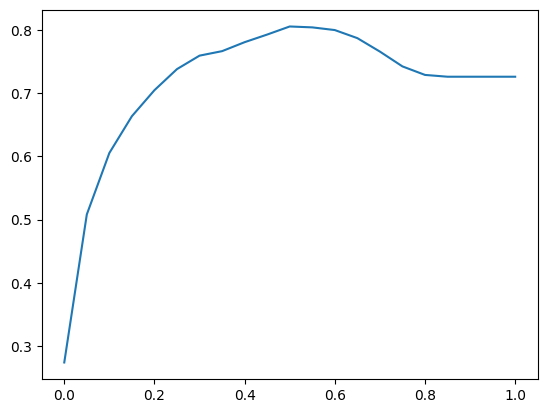

In [728]:
plt.plot(thresholds, scores)

In [729]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [730]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

### 4.3 Confusion table
- Different types of erros and correct decisions
- Arranging them in table


In [731]:
actual_positive = y_val == 1
actual_negative = y_val == 0

In [732]:
t = 0.5
predicted_positive = y_pred >= t
predicted_negative = y_pred < t

In [733]:
tp = (predicted_positive & actual_positive).sum()
tp

np.int64(212)

In [734]:
tn = (predicted_negative & actual_negative).sum()
tn

np.int64(923)

In [735]:
fp = (predicted_positive & actual_negative).sum()
fp

np.int64(100)

In [736]:
fn = (predicted_negative & actual_positive).sum()
fn

np.int64(174)

In [737]:
confusion_matrix = np.array(
    [
        [tn, fp],
        [fn, tp],
    ]
)
confusion_matrix

array([[923, 100],
       [174, 212]])

In [738]:
(confusion_matrix / confusion_matrix.sum()).round(3)

array([[0.655, 0.071],
       [0.123, 0.15 ]])

### 4.4 Precision and Recall

In [739]:
p = tp / (tp + fp)
p

np.float64(0.6794871794871795)

In [740]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

### 4.5 ROC Curves

- True Positive Rate = $ tp/(tp+fn) $
- False Positive Rate = $ fp/(fp+tn) $


In [741]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [742]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09775171065493646)

In [743]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predicted_positive = y_pred >= t
    predicted_negative = y_pred < t

    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    scores.append((t, tp, fp, fn, tn))
columns = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [744]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,537,19,486,0.950777,0.524927
20,0.2,337,367,49,656,0.873057,0.358749
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,252,175,134,848,0.652850,0.171065
50,0.5,212,100,174,923,0.549223,0.097752
60,0.6,155,51,231,972,0.401554,0.049853
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


In [745]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,901,1,122,0.997409,0.880743
2,0.02,383,808,3,215,0.992228,0.789834
3,0.03,382,753,4,270,0.989637,0.736070
4,0.04,382,714,4,309,0.989637,0.697947
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


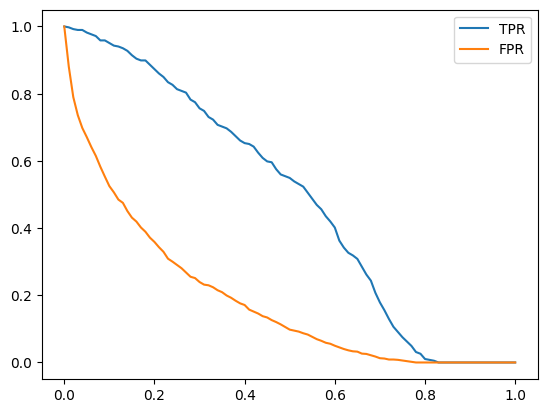

In [746]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

### Random model

In [747]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [748]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [749]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0

        predicted_positive = y_pred >= t
        predicted_negative = y_pred < t

        tp = (actual_positive & predicted_positive).sum()
        tn = (actual_negative & predicted_negative).sum()
        fp = (actual_negative & predicted_positive).sum()
        fn = (actual_positive & predicted_negative).sum()

        scores.append((t, tp, fp, fn, tn))
    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [750]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

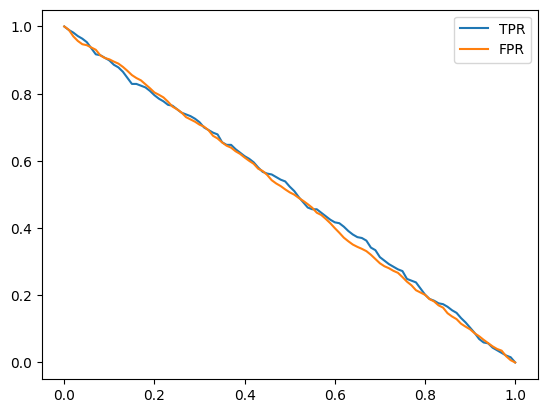

In [751]:
plt.plot(df_rand.threshold, df_rand["tpr"], label="TPR")
plt.plot(df_rand.threshold, df_rand["fpr"], label="FPR")
plt.legend()

### Ideal model
